Epoch 0: Loss = 0.6925
Epoch 100: Loss = 0.6906
Epoch 200: Loss = 0.6882
Epoch 300: Loss = 0.6846
Epoch 400: Loss = 0.6792
Epoch 500: Loss = 0.6712
Epoch 600: Loss = 0.6596
Epoch 700: Loss = 0.6426
Epoch 800: Loss = 0.6192
Epoch 900: Loss = 0.5879
Epoch 1000: Loss = 0.5483
Epoch 1100: Loss = 0.5006
Epoch 1200: Loss = 0.4479
Epoch 1300: Loss = 0.3946
Epoch 1400: Loss = 0.3446
Epoch 1500: Loss = 0.2999
Epoch 1600: Loss = 0.2614
Epoch 1700: Loss = 0.2288
Epoch 1800: Loss = 0.2013
Epoch 1900: Loss = 0.1782
Epoch 2000: Loss = 0.1587
Epoch 2100: Loss = 0.1421
Epoch 2200: Loss = 0.1280
Epoch 2300: Loss = 0.1158
Epoch 2400: Loss = 0.1053
Epoch 2500: Loss = 0.0962
Epoch 2600: Loss = 0.0882
Epoch 2700: Loss = 0.0812
Epoch 2800: Loss = 0.0750
Epoch 2900: Loss = 0.0696
Epoch 2999: Loss = 0.0647
Predictions: ['Sepia', 'Sepia', 'Normal', 'Normal', 'Normal', 'Normal', 'Sepia', 'Sepia', 'Normal', 'Sepia']
Actual: ['Sepia', 'Sepia', 'Sepia', 'Normal', 'Normal', 'Normal', 'Sepia', 'Sepia', 'Normal', 'Se

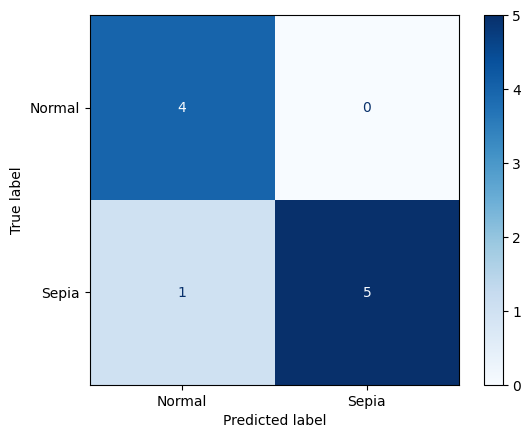

In [7]:
import numpy as np
from PIL import Image
import os
import io
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def resize_and_flatten(images, target_size=(32, 32)):
    resized_images = []
    for img in images:
        img_resized = img.resize(target_size)
        img_array = np.array(img_resized)
        img_flattened = img_array.flatten()
        resized_images.append(img_flattened)
    return np.array(resized_images)

def loadData():
    currentPath = os.getcwd()
    currentPath = os.path.join(currentPath, "Photos")
    inputs = []
    outputs = []

    for file in os.listdir(currentPath):
        if "person" in file:
            outputs.append("Normal")
        else:
            outputs.append("Sepia")

        file_path = os.path.join(currentPath, file)
        with open(file_path, mode="rb") as f:
            image = Image.open(io.BytesIO(f.read()))
            image = image.convert('RGB')
            inputs.append(image)

    return inputs, outputs

def splitData(inputs, outputs):
    np.random.seed(5)
    indexes = np.arange(len(inputs))
    np.random.shuffle(indexes)
    split_point = int(0.8 * len(inputs))
    train_idx, test_idx = indexes[:split_point], indexes[split_point:]

    trainInputs = [inputs[i] for i in train_idx]
    trainOutputs = [outputs[i] for i in train_idx]
    testInputs = [inputs[i] for i in test_idx]
    testOutputs = [outputs[i] for i in test_idx]

    return trainInputs, trainOutputs, testInputs, testOutputs

def encode_labels(labels):
    return np.array([[1, 0] if label == "Normal" else [0, 1] for label in labels])

def decode_labels(one_hot_preds):
    return ["Normal" if np.argmax(row) == 0 else "Sepia" for row in one_hot_preds]

class SimpleANN:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.W1 = np.random.randn(self.input_size, self.hidden_size) * 0.01
        self.b1 = np.zeros((1, self.hidden_size))
        self.W2 = np.random.randn(self.hidden_size, self.output_size) * 0.01
        self.b2 = np.zeros((1, self.output_size))

    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, z):
        return z > 0

    def softmax(self, z):
        e_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return e_z / np.sum(e_z, axis=1, keepdims=True)

    def forward(self, X):
        self.Z1 = X @ self.W1 + self.b1
        self.A1 = self.relu(self.Z1)
        self.Z2 = self.A1 @ self.W2 + self.b2
        self.A2 = self.softmax(self.Z2)
        return self.A2

    def compute_loss(self, Y_hat, Y):
        m = Y.shape[0]
        loss = -np.sum(Y * np.log(Y_hat + 1e-9)) / m
        return loss

    def backward(self, X, Y):
        m = X.shape[0]
        dZ2 = self.A2 - Y
        dW2 = self.A1.T @ dZ2 / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * self.relu_derivative(self.Z1)
        dW1 = X.T @ dZ1 / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        return dW1, db1, dW2, db2

    def update_params(self, dW1, db1, dW2, db2, lr):
        self.W1 -= lr * dW1
        self.b1 -= lr * db1
        self.W2 -= lr * dW2
        self.b2 -= lr * db2

    def fit(self, X, Y, epochs=1000, lr=0.01):
        for epoch in range(epochs):
            Y_hat = self.forward(X)
            loss = self.compute_loss(Y_hat, Y)
            dW1, db1, dW2, db2 = self.backward(X, Y)
            self.update_params(dW1, db1, dW2, db2, lr)

            if epoch % 100 == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch}: Loss = {loss:.4f}")

    def predict(self, X):
        probs = self.forward(X)
        return decode_labels(probs)

inputs, outputs = loadData()
inputs_flat = resize_and_flatten(inputs, target_size=(32, 32))
trainInputs, trainOutputs, testInputs, testOutputs = splitData(inputs_flat, outputs)

trainInputs = np.array(trainInputs) / 255.0
testInputs = np.array(testInputs) / 255.0
trainOutputs_enc = encode_labels(trainOutputs)

model = SimpleANN(input_size=trainInputs.shape[1], hidden_size=10, output_size=2)
model.fit(trainInputs, trainOutputs_enc, epochs=3000, lr=0.001)

predictions = model.predict(testInputs)

print("Predictions:", predictions)
print("Actual:", testOutputs)
print(f"Accuracy: {accuracy_score(testOutputs, predictions):.4f}")
print("Classification Report:")
print(classification_report(testOutputs, predictions))

cm = confusion_matrix(testOutputs, predictions, labels=["Normal", "Sepia"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Sepia"])
disp.plot(cmap="Blues")
plt.show()
